In [2]:
from time import time
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import itertools
import datetime

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"] = ""
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Lambda
import keras.backend as K
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [3]:
TRAIN_CSV = 'data/train_snli.txt'
EMBEDDING_FILE = 'data/GoogleNews-vectors-negative300.bin.gz'
MODEL_SAVING_DIR = 'data/snli/'
questions_cols = ['question1', 'question2']

In [4]:
train_df = pd.read_csv(TRAIN_CSV, sep='\t', header=None,  names=questions_cols+['dv'])

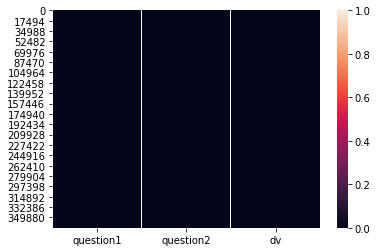

In [5]:
sns.heatmap(train_df.isna())

In [6]:
# Prepare embedding
vocabulary = dict()
inverse_vocabulary = ['<unk>']  # '<unk>' will never be used, it is only a placeholder for the [0, 0, ....0] embedding
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [7]:
print(train_df.shape)

(367373, 3)


In [8]:
train_df.head()

,question1,question2,dv
0,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",0
1,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",1
2,Children smiling and waving at camera,There are children present,1
3,Children smiling and waving at camera,The kids are frowning,0
4,A boy is jumping on skateboard in the middle o...,The boy skates down the sidewalk.,0


In [9]:
# Iterate over the questions only of both training and test datasets
for index, row in train_df.iterrows():
    try:
    # Iterate through the text of both questions of the row
        for question in questions_cols:

            q2n = []  # q2n -> question numbers representation
            for word in row[question]:
                if word not in vocabulary:
                    vocabulary[word] = len(inverse_vocabulary)
                    q2n.append(len(inverse_vocabulary))
                    inverse_vocabulary.append(word)
                else:
                    q2n.append(vocabulary[word])

            # Replace questions as word to question as number representation
            #dataset.at[index, question] = q2n
            train_df.set_value(index, question, q2n)
    except:
        print(index)
            
embedding_dim = 300
embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  # This will be the embedding matrix
embeddings[0] = 0  # So that the padding will be ignored

# Build the embedding matrix
for word, index in vocabulary.items():
    if word in word2vec.vocab:
        embeddings[index] = word2vec.word_vec(word)

#del word2vec

C:\Users\subhashree hazra\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


61111
61112
207766
207767


In [10]:
index = list(train_df.index)

In [11]:
for i in [61111,
61112,
207766,
207767]:
    
    index.remove(i)

In [12]:
train_df = train_df.iloc[index]

In [13]:
train_df.head()

,question1,question2,dv
0,"[1, 2, 3, 4, 5, 6, 7, 8, 2, 7, 8, 2, 9, 2, 10,...","[1, 2, 3, 4, 5, 6, 7, 8, 2, 19, 6, 2, 9, 22, 2...",0
1,"[1, 2, 3, 4, 5, 6, 7, 8, 2, 7, 8, 2, 9, 2, 10,...","[1, 2, 3, 4, 5, 6, 7, 8, 2, 19, 6, 2, 7, 12, 2...",1
2,"[25, 10, 19, 20, 17, 5, 4, 8, 2, 6, 13, 19, 20...","[27, 10, 4, 5, 4, 2, 9, 5, 4, 2, 26, 10, 19, 2...",1
3,"[25, 10, 19, 20, 17, 5, 4, 8, 2, 6, 13, 19, 20...","[27, 10, 4, 2, 16, 19, 17, 6, 2, 9, 5, 4, 2, 2...",0
4,"[1, 2, 15, 7, 29, 2, 19, 6, 2, 11, 12, 13, 3, ...","[27, 10, 4, 2, 15, 7, 29, 2, 6, 16, 9, 22, 4, ...",0


In [14]:
max_seq_length = max(train_df.question1.map(lambda x: len(x)).max(),
                     train_df.question2.map(lambda x: len(x)).max())

# Split to train validation
validation_size = 40000
training_size = len(train_df) - validation_size

X = train_df[questions_cols]
Y = train_df['dv']

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size)


In [15]:
# Split to dicts
X_train =      {'left': X_train.question1,      'right': X_train.question2}
X_validation = {'left': X_validation.question1, 'right': X_validation.question2}

# Convert labels to their numpy representations
Y_train      = Y_train.values
Y_validation = Y_validation.values

# Zero padding
for dataset, side in itertools.product([X_train, X_validation], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

# Make sure everything is ok
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

In [16]:
404290 - 40000

364290

In [17]:
# Model variables
n_hidden = 50
gradient_clipping_norm = 1.25
#batch_size = 64
#n_epoch = 25
batch_size = 250
n_epoch = 10

def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

In [18]:
# The visible layer
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = LSTM(n_hidden)

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

# Calculates the distance as defined by the MaLSTM model
malstm_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

# Pack it all up into a model
malstm = Model([left_input, right_input], [malstm_distance])

# Adadelta optimizer, with gradient clipping by norm
optimizer = Adadelta(clipnorm=gradient_clipping_norm)

malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

# Start training
training_start_time = time()

malstm_trained = malstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation))

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

InternalError: cudaGetDevice() failed. Status: CUDA driver version is insufficient for CUDA runtime version

In [ ]:
# Plot accuracy
plt.plot(malstm_trained.history['accuracy'])
plt.plot(malstm_trained.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Plot loss
plt.plot(malstm_trained.history['loss'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()